In [1]:
import numpy as np
from pathlib import Path
import json 

## Generate the skip trigram dataset
$$
\begin{array}{lll}
{[0] \ldots[1]} & \rightarrow & {[6]} \\
{[0] \ldots[2]} & \rightarrow & {[7]} \\
{[0] \ldots[3]} & \rightarrow & {[8]} \\
{[0] \ldots[4]} & \rightarrow & {[9]} \\
{[0] \ldots[5]} & \rightarrow & {[10]}
\end{array}
$$

In [2]:
import numpy as np

num_examples = 100000
subseq_length = 3
total_length = 20
max_digit = 10

def generate_sequences(N, L, total_len):
    sequences = []
    labels = []

    for _ in range(N):
        # Generate a random sequence
        sequence = np.random.randint(1, max_digit+1, total_len)

        # Choose a random start position for the subsequence
        start_pos = np.random.randint(0, total_len - L)

        # Generate the subsequence
        subsequence = np.concatenate(([0], np.random.randint(1, max_digit-4, L-2), np.random.randint(1, max_digit-4, 1)))

        # Insert the subsequence into the sequence
        sequence[start_pos:start_pos + L] = subsequence
        
        # Prepend max_digit+1 to sequence as a special token
        # sequence = np.concatenate(([max_digit+1], sequence))

        # Create a label that is +5 of the final number of the subsequence
        label = subsequence[-1] + 5

        sequences.append(sequence)
        labels.append(label)

    return sequences, labels

seqs, labels = generate_sequences(num_examples, subseq_length, total_length)
seqs_val, labels_val = generate_sequences(1000, subseq_length, total_length)
_ = [print(seq, labels[i]) for i, seq in enumerate(seqs) if i < 10]

[ 5  3  8  8  2 10  2  9  8  4  7  5  5  0  1  5  5  3  4  4] 10
[ 3  5  0  5  1  5  4  4  6  8  5  5  9  3  5  3  6 10  5  4] 6
[0 5 2 6 5 4 5 1 1 3 9 5 7 8 2 7 7 9 6 4] 7
[ 6  5  7  3  5  9  5  7  2  5 10  1  6  4  0  3  5  6  8  3] 10
[10  8  6  7  3  1  1  0  1  4  9  8  7 10  2  3  7  9  3  6] 9
[ 6  7  0  2  3  1  8  7  8  8 10  4  5  7  8  5  3  7  5  5] 8
[3 2 0 4 5 7 1 7 9 8 5 4 3 9 3 7 8 4 4 4] 10
[10  2  9  6  8  4  8  0  1  3  3  3 10  1  7  1  3 10  8  2] 8
[8 9 7 1 0 1 2 1 7 9 7 7 1 6 9 1 3 7 4 9] 7
[ 2  9  7  3  4  6  6  4  8  4  4  9  0  4  3  5 10  7  5  3] 8


In [3]:
from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch

retrain = True
data_dir = Path('data')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_heads = 3
cfg = HookedTransformerConfig(
    n_layers = 1,
    d_model  = num_heads*16,
    d_head   = 16,
    n_heads  = num_heads,
    d_mlp    = 64,
    d_vocab  = max_digit,
    n_ctx    = total_length,
    attn_only= False,
    act_fn   = 'relu',
    device   = device,
)

# Search for model with matching cfg
loaded_model = False
if not retrain:
    for model_cfg_path in data_dir.glob('**/cfg.json'):
        with open(model_cfg_path) as f:
            model_cfg = json.load(f)
        if model_cfg == cfg.__dict__:
            print(f'Found matching model at {model_cfg_path.parent}')
            loaded_model = True
            state_dict = torch.load(model_cfg_path.parent / 'model.pt', map_location=device)
            break

In [4]:
from torch import nn
import math
# Train a simple 1 layer model
from fancy_einsum import einsum

class PositionalEncoding(nn.Module):

    def __init__(self, d_vocab, d_model: int, max_len: int = 5000):
        super().__init__()
        d_pos_enc = d_model-(d_vocab+1)
        if d_pos_enc % 2 != 0:
            d_pos_enc = d_pos_enc - 1

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_pos_enc, 2) * (-math.log(max_len*2) / d_pos_enc))
        pe = torch.zeros(max_len, 1, d_pos_enc)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        # Left pad with zeros if necessary
        if d_pos_enc < d_model:
            pe = torch.cat([torch.zeros(max_len, 1, d_model - d_pos_enc), pe], dim=-1)

        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x.transpose(0, 1) # B, S -> S, B
        x = x + self.pe[:x.size(0), :]
        x = x.transpose(0, 1) # S, B -> B, S
        return x

class SimpleTransformer(torch.nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # One hot embeddings
        self.embedding = torch.nn.Embedding(cfg.d_vocab+1, cfg.d_model)
        eye_matrix = torch.eye(cfg.d_vocab+1) 
        eye_matrix = torch.cat([eye_matrix, torch.zeros(cfg.d_vocab+1, cfg.d_model - (cfg.d_vocab+1))], dim=1)
        self.embedding.weight = torch.nn.Parameter(eye_matrix, requires_grad=False)

        self.pos_encod = PositionalEncoding(cfg.d_vocab, cfg.d_model, max_len=cfg.n_ctx)

        if cfg.attn_only:
            self.layer = torch.nn.MultiheadAttention(cfg.d_model, cfg.n_heads)
        else:
            self.layer = torch.nn.TransformerEncoderLayer(cfg.d_model, cfg.n_heads, norm_first=True, batch_first=True, dropout=0, activation=cfg.act_fn, dim_feedforward=cfg.d_mlp)
            # remove bias manually
            self.layer.self_attn.in_proj_bias = None
            self.layer.self_attn.out_proj.bias = None

    def forward(self, x):
        inp = x.clone()

        x = self.embedding(x)
        x = self.pos_encod(x)
        
        # attend residually
        x = self.layer(x)
        
        # We will gather the logits for the "0" token from the original sequence
        zero_posns = (inp == 0).nonzero()[:,1]
        x = torch.gather(x, 1, zero_posns.unsqueeze(1).repeat(1, x.shape[2]).unsqueeze(1))

        # Unembed with the embedding
        return x.squeeze(1)@self.embedding.weight.T #+ self.unembedding.bias

model = SimpleTransformer(cfg).to(device)

# tokenize by using onehot
sample_in = torch.tensor(seqs[:1], device=device)

model(sample_in).shape

/var/folders/7r/mxsffy3s1xn40wbtsc3zr6680000gn/T/ipykernel_28183/3773685120.py:75: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  sample_in = torch.tensor(seqs[:1], device=device)


torch.Size([1, 11])

In [5]:
a = torch.tensor([[9, 2, 8, 6, 3, 1, 3, 6, 1, 8, 2, 0, 2, 1, 8, 4, 5, 3, 2, 4, 8],
        [9, 1, 1, 1, 2, 2, 3, 8, 0, 2, 2, 1, 8, 8, 7, 5, 4, 5, 5, 6, 2],
        [9, 1, 2, 2, 3, 5, 5, 5, 7, 6, 7, 4, 3, 0, 2, 2, 2, 2, 6, 5, 5]])

zeros = (a == 0).nonzero()[:,1]
print(zeros)
gathered = torch.gather(a, 1, zeros.unsqueeze(1))
print(gathered)

tensor([11,  8, 13])
tensor([[0],
        [0],
        [0]])


In [6]:
def validate_model(model, val_seqs, val_labels):
    # Get skiptrigram accuracy, for each different skip trigram
    batch_size = 128
    trigram_accuracies = {k:0 for k in range(max_digit-4, max_digit+1)}
    trigram_counts = {k:0 for k in range(max_digit-4, max_digit+1)}
    with torch.no_grad():
        for i in range(0, len(seqs), batch_size):
            end_idx = min(i+batch_size, len(seqs))
            batch_data, batch_labels = seqs[i:end_idx], labels[i:end_idx]

            batch_data = torch.tensor(batch_data).to(device).long()
            batch_labels = torch.tensor(batch_labels).to(device)
            # batch_labels = batch_labels - 6

            pred = model(batch_data)
            for k, v in trigram_accuracies.items():
                relevant_labels = (batch_labels == k)
                relevant_pred = pred[relevant_labels]
                relevant_labels = relevant_pred.argmax(dim=1).eq(k)
                trigram_accuracies[k] += relevant_labels.sum().item()
                trigram_counts[k] += len(relevant_labels)
    trigram_accuracies = {k : v/trigram_counts[k]  for k, v in trigram_accuracies.items()}
    return trigram_accuracies 
print(validate_model(model, seqs_val, labels_val))

{6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0}


In [10]:
# Train in batches
# from csv import writer
from operator import le
import pickle
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

batch_size = 128
num_epochs = 6
run_validation = False

model = SimpleTransformer(cfg).to(device)
if loaded_model and not retrain:
    model.load_state_dict(state_dict)
else:

    validation_accs = []
    # Set tensorboard directory to be in data/logs
    runs = list(Path('./data/').glob('model_*'))
    last_run = sorted(runs)[-1] if len(runs) > 0 else Path('./data/model_0')
    model_save_id = str(int(last_run.name.split('_')[-1])+1)
    writer = SummaryWriter(log_dir=data_dir / ('logs/model_' + model_save_id))
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Save model and cfg in a directory 
    dir_name = Path('data/model_' + model_save_id)
    dir_name.mkdir(exist_ok=True)

    # Add progress bar with loss 
    pbar = tqdm(total=len(seqs)*num_epochs, desc='Training', unit='seqs')

    step = 0
    for epoch in range(num_epochs):
        for i in range(0, len(seqs), batch_size):
            end_idx = min(i+batch_size, len(seqs))
            batch_data, batch_labels = seqs[i:end_idx], labels[i:end_idx]
            batch_data = torch.tensor(batch_data).to(device).long()
            # batch_data = torch.nn.functional.one_hot(batch_data, max_digit+1).float()
            batch_labels = torch.tensor(batch_labels).to(device)
            # batch_labels = batch_labels - 6

            pred = model(batch_data)

            loss = torch.nn.functional.cross_entropy(pred, batch_labels)

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # log to tensorboard
            writer.add_scalar('Loss/train', loss.item(), step)

            # Update Progress Bar
            pbar.update(batch_size)
            pbar.set_postfix(loss=loss.item())
            step += 1
            if (i % 100 == 0) and run_validation:
                # validate the model 
                validation_accs.append(validate_model(model, seqs_val, labels_val))
                # checkpoint the model
                torch.save(model.state_dict(), dir_name/f'model_ckpt_{i}.pt')

    torch.save(model.state_dict(), dir_name/'model_final.pt')
    with open(dir_name/'cfg.json', 'w') as f:
        json.dump(cfg.__dict__, f)

    # pickle dump the validation accuracies
    pickle.dump(validation_accs, open(dir_name/'validation_accs.pkl', 'wb'))

Training:   0%|          | 0/600000 [00:00<?, ?seqs/s]

Training: 600576seqs [01:16, 8186.94seqs/s, loss=0.000386]                          

Training: 600576seqs [01:30, 8186.94seqs/s, loss=0.000386]

In [11]:
import matplotlib.pyplot as plt
if loaded_model or run_validation:
    # plot validation accs for each trigram throughout training
    if loaded_model or not retrain:
        validation_accs = pickle.load(open(dir_name/'validation_accs.pkl', 'rb'))
    validation_acc_flipped = {k: np.concatenate([np.array([v[k] for v in validation_accs])]) for k in range(max_digit-4, max_digit+1)}

    f, ax = plt.subplots()
    for target in validation_acc_flipped.keys():
        ax.plot(validation_acc_flipped[target], label=f"[0]...[{target-4}]->[{target}]")
        
    plt.legend()


In [12]:
# import matplotlib.pyplot as plt
# qkv = model.layer.self_attn.in_proj_weight
# q, k, v = qkv.chunk(3, dim=0)
# qk = k.T@q

# # decompose by head
# f, ax = plt.subplots(2, cfg.n_heads//2, figsize=(10, 10))
# for i in range(cfg.n_heads):
#     q_head = q[i*cfg.d_model//cfg.n_heads:(i+1)*cfg.d_model//cfg.n_heads]
#     k_head = k[i*cfg.d_model//cfg.n_heads:(i+1)*cfg.d_model//cfg.n_heads]
    
#     qk_head = k_head.T@q_head
#     unembedded = model.embedding.weight@qk_head@model.embedding.weight.T
#     unembedded = unembedded.detach().cpu().numpy().T

#     ax[i//2, i%2].imshow(unembedded, cmap='RdBu')
#     ax[i//2, i%2].set_xticks(np.arange(0, max_digit+1))
#     ax[i//2, i%2].set_yticks(np.arange(0, max_digit+1))
#     ax[i//2, i%2].set_xlabel('To (Key)')
#     ax[i//2, i%2].set_ylabel('From (Query)')

#     ax[i//2, i%2].set_title(f'Head {i+1}')


In [13]:
import nice_hooks

# Now let's do a bunch of manual shizz to convince ourselves that the model is working
# first we'll manually pass through an example
print(f"max digit is {max_digit} so maximum trigram is {max_digit}")
simple_seq = torch.tensor([0,2,5], device=device).unsqueeze(0)
print(model(simple_seq).argmax(dim=-1))

output, cache = nice_hooks.run(model, simple_seq, return_activations=True)
print(cache['layer'][0].shape, model.embedding.weight.shape)
print(einsum('b d,v d->b v', cache['layer'][0], model.embedding.weight))
print(output)

max digit is 10 so maximum trigram is 10
tensor([10])
torch.Size([3, 48]) torch.Size([11, 48])
tensor([[-2.1633, -3.0077, -4.1647, -4.3350, -1.8267, -2.7459, -2.4996,  0.4773,
         -2.0696, -4.2558,  9.4289],
        [-3.3756, -3.1723, -3.2692, -4.5118, -1.8830, -2.8241, -2.6730,  0.0676,
         -1.9535, -4.4172,  9.7974],
        [-3.2779, -2.8412, -4.0776, -4.4719, -1.7272, -1.5662, -2.8568,  0.3908,
         -1.7557, -3.9745,  9.4457]], grad_fn=<ViewBackward0>)
tensor([[-2.1633, -3.0077, -4.1647, -4.3350, -1.8267, -2.7459, -2.4996,  0.4773,
         -2.0696, -4.2558,  9.4289]], grad_fn=<MmBackward0>)


In [14]:
from arrgh import arrgh
arrgh(**cache)

ModuleNotFoundError: No module named 'arrgh'

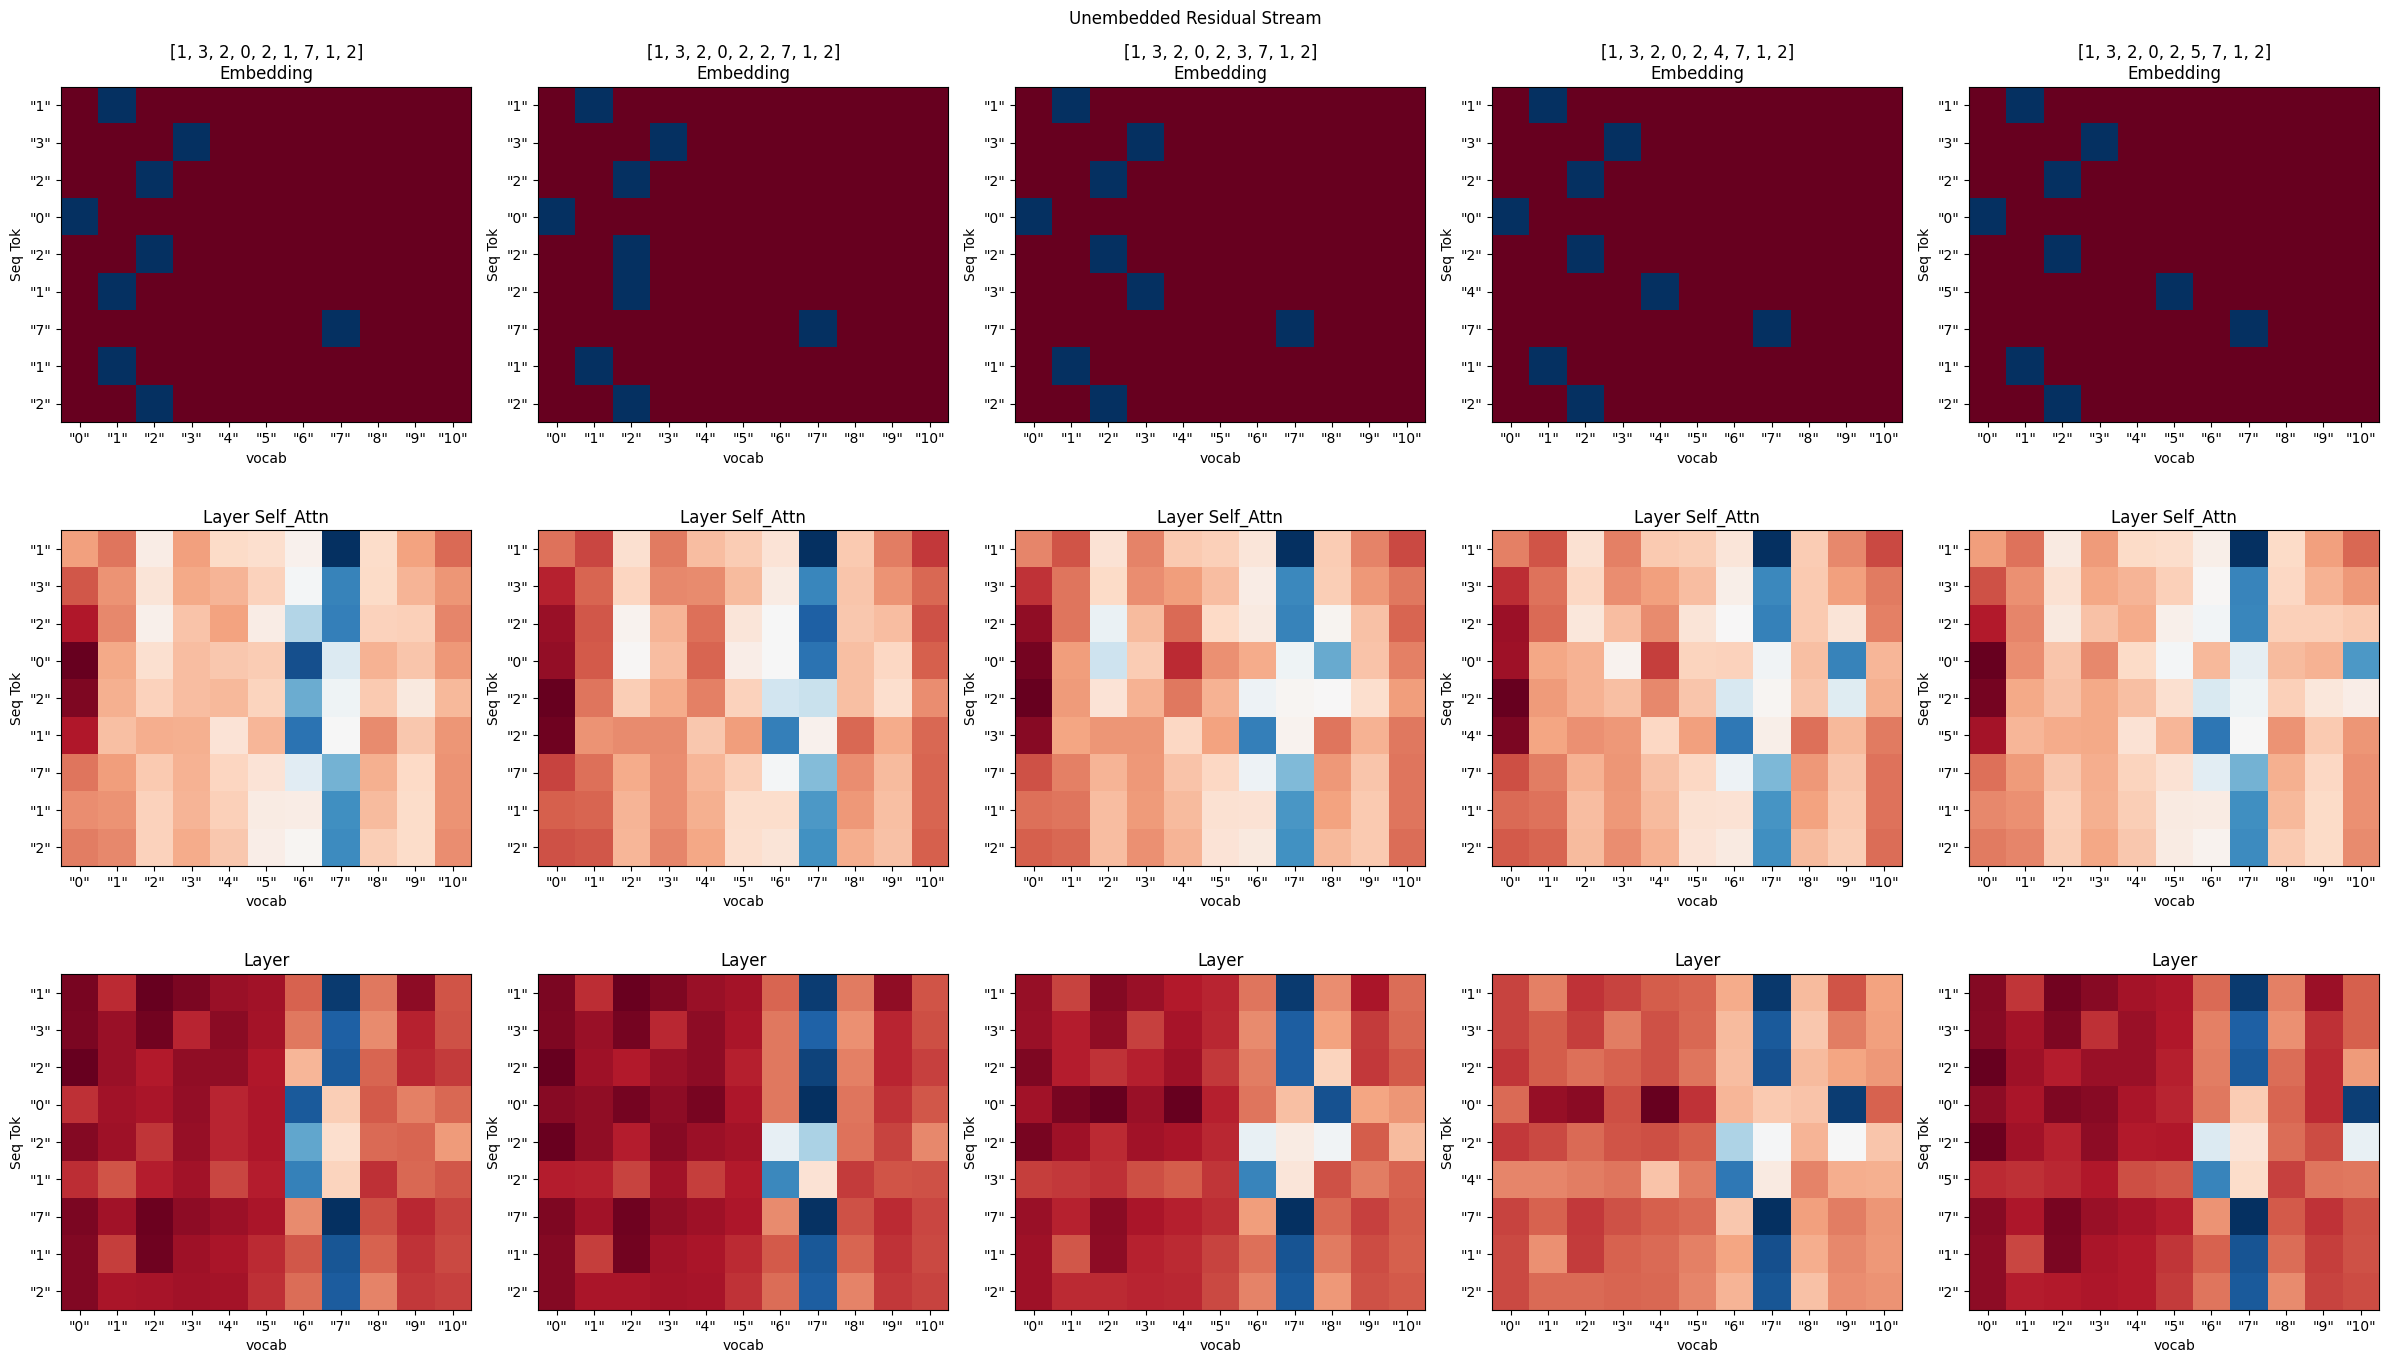

In [15]:
layers = ['embedding', 'layer.self_attn', 'layer']

f, ax = plt.subplots(len(layers), 5, figsize=(len(layers)*8, 14))
for j, seq_end in enumerate([1,2,3,4,5]):
    simple_seq = torch.tensor([1,3,2,0,2,seq_end,7,1,2], device=device).unsqueeze(0)
    output, cache = nice_hooks.run(model, simple_seq, return_activations=True)

    for i, layer in enumerate(layers):
        title = f'{layer.replace("."," ").title()}'
        if i == 0:
            title = f'{simple_seq.tolist()[0]}\n{title}'
        ax[i,j].set_title(title)
        layer_stream = cache[layer][0] if isinstance(cache[layer], tuple) else cache[layer]
        unembedded_layer = einsum('v d, b s d -> b s v', model.embedding.weight, layer_stream)
        ax[i,j].imshow(unembedded_layer.detach().cpu().numpy()[0], cmap='RdBu')
        ax[i,j].set_xticks(np.arange(0, max_digit+1), [f'"{x}"' for x in np.arange(0, max_digit+1)])
        ax[i,j].set_yticks(np.arange(0, simple_seq.shape[1]), [f'"{x}"' for x in simple_seq.tolist()[0]])
        ax[i,j].set_ylabel('Seq Tok')
        ax[i,j].set_xlabel('vocab')

f.suptitle('Unembedded Residual Stream')
plt.tight_layout()
plt.savefig('results/unembedded_residual_stream_0_2_X.png')
# unembedded_attn = model.embedding.weight@attn_out@model.embedding.weight.T

## Isolate the effect on the final token of the skip trigram

In [ ]:
layers_to_plot = [x for x in cache.keys() if list(cache[x][0].shape)[-1] == 64 and 'dropout' not in x and x != 'layer']
print(layers_to_plot)

['layer.linear1']


max digit is 10 so maximum trigram is 10
for seq [1, 3, 2, 0, 2, 1, 7, 1, 2] the output is 6
max digit is 10 so maximum trigram is 10
for seq [1, 3, 2, 0, 2, 2, 7, 1, 2] the output is 7
max digit is 10 so maximum trigram is 10
for seq [1, 3, 2, 0, 2, 3, 7, 1, 2] the output is 8
max digit is 10 so maximum trigram is 10
for seq [1, 3, 2, 0, 2, 4, 7, 1, 2] the output is 9
max digit is 10 so maximum trigram is 10
for seq [1, 3, 2, 0, 2, 5, 7, 1, 2] the output is 10


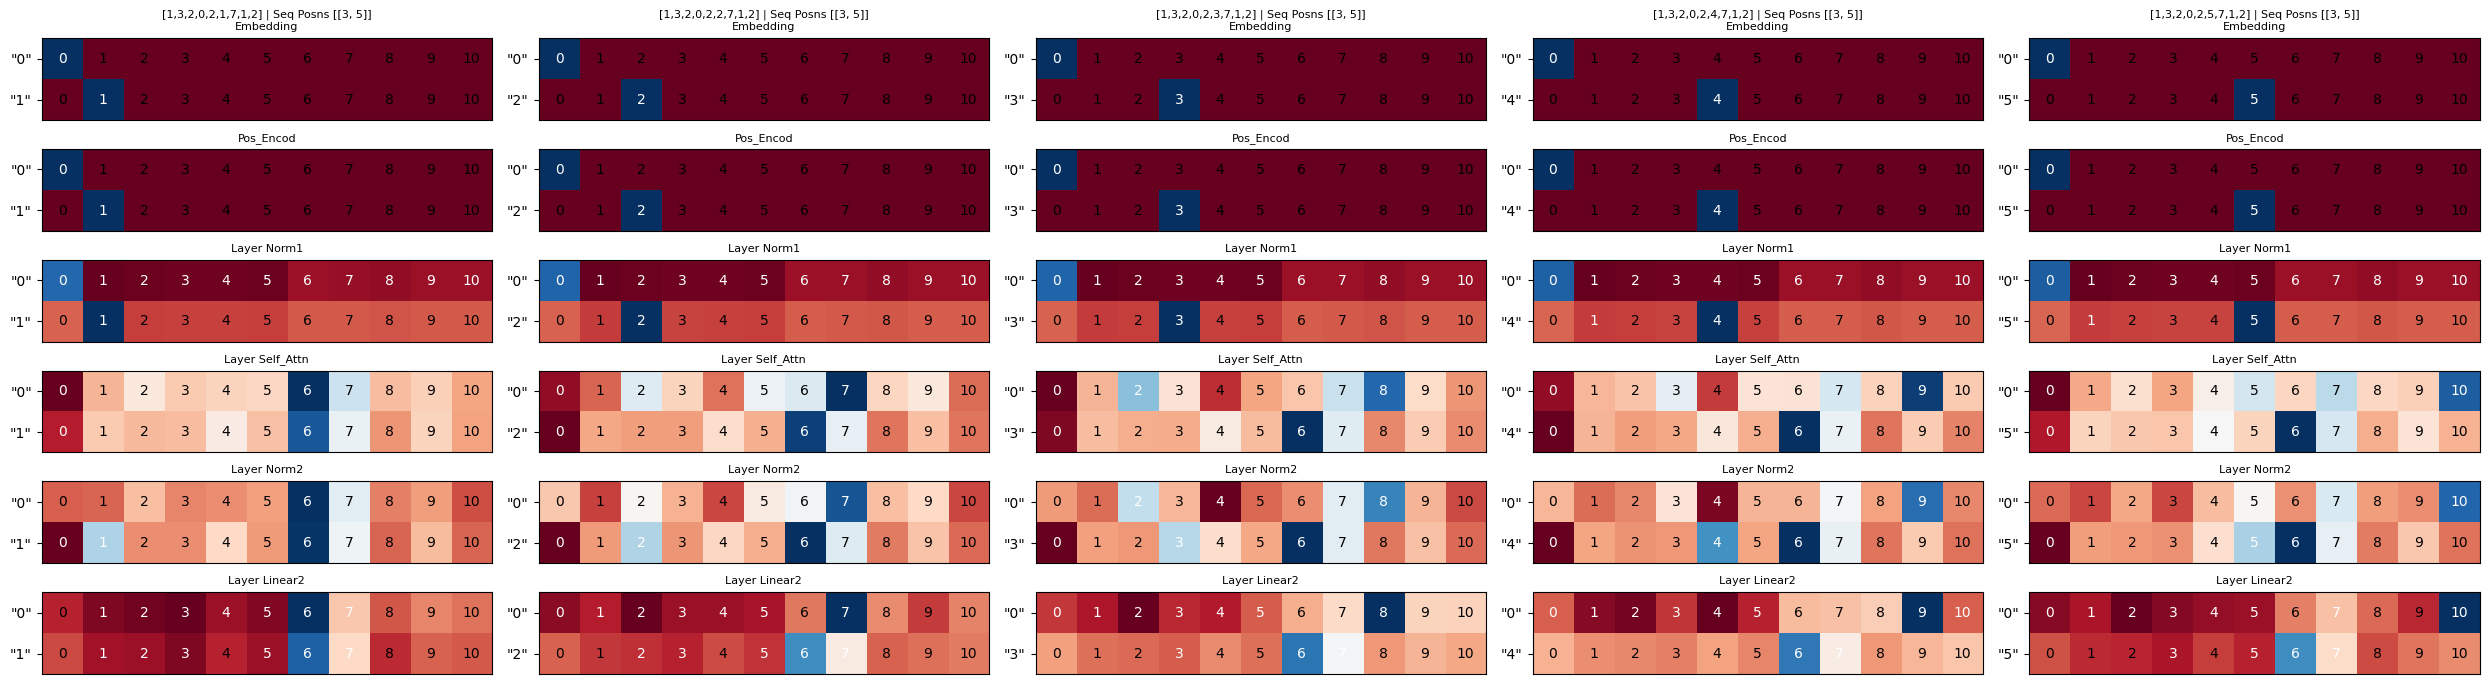

In [16]:
layers = ['embedding', 'layer.self_attn', 'layer']

ending_ints = [1,2,3,4,5]
f, ax = plt.subplots(6, len(ending_ints), figsize=(len(ending_ints)*5,7))

token_posns_of_interest = [[3,5]]

for j, seq_end in enumerate(ending_ints):
    extracted_token_bla = {}
    simple_seq = torch.tensor([1,3,2,0,2,seq_end,7,1,2], device=device).unsqueeze(0)
    output, cache = nice_hooks.run(model, simple_seq, return_activations=True)
    print(f"max digit is {max_digit} so maximum trigram is {max_digit}")
    print(f'for seq {simple_seq.tolist()[0]} the output is {output.argmax(dim=-1).tolist()[0]}')


    for i, layer in enumerate(cache.keys()):
        token_vals = cache[layer][0].squeeze(0)
        if token_vals.ndim == 1:
            continue
        # gather tokens of interest
        extracted_token_bla[layer] = token_vals[token_posns_of_interest]# torch.gather(token_vals, dim=0, index=torch.tensor(token_posns_of_interest, device=device)).squeeze(-1) 

    layers_to_plot = [x for x in extracted_token_bla if list(extracted_token_bla[x].shape)[-1] == cfg.d_model and 'dropout' not in x and x != 'layer']

    for i, layer in enumerate(layers_to_plot):
        unembedded_layer = einsum('v d, s d -> s v', model.embedding.weight, extracted_token_bla[layer])
        layer_data = unembedded_layer.detach().cpu().numpy()

        # Displaying the matrix
        cax = ax[i,j].matshow(layer_data, cmap='RdBu')

        title = f'{layer.replace("."," ").title()}'
        if i == 0:
            title = f'{str(simple_seq.tolist()[0]).replace(" ","")} | Seq Posns {token_posns_of_interest}\n{title}'
        ax[i,j].set_title(title, fontsize=8)

        # Iterate over the data and create a text for each cell.
        threshold = layer_data.mean() + layer_data.std()

        # Iterate over the data and create a text for each cell.
        for (m, n), z in np.ndenumerate(layer_data):
            # The color of the text depends on the data value
            color = 'white' if abs(z - layer_data.mean()) > threshold else 'black'
            ax[i,j].text(n, m, f'{n}', ha='center', va='center',
                         bbox=dict(boxstyle='round', facecolor='none', edgecolor='none'),
                         color=color)
        ax[i,j].set_xticks([])
        tokens_shown = simple_seq[0,token_posns_of_interest[0]]
        ax[i,j].set_yticks(range(len(token_posns_of_interest[0])), [f'"{x}"' for x in tokens_shown])
plt.tight_layout()
plt.savefig('results/extracted_token_model_forwardpass.png')
None

skip trigram ending  5  prediction  10


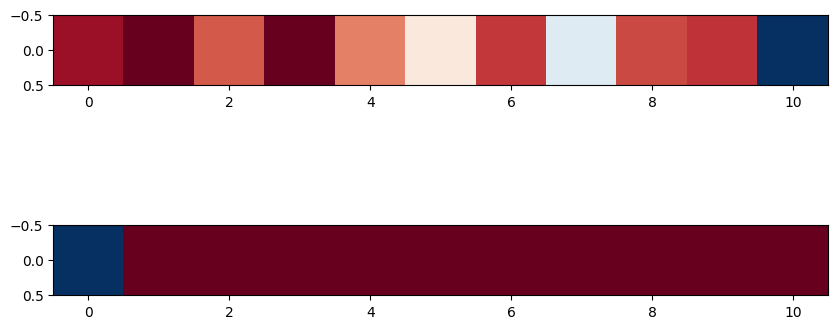

In [17]:
"""
x = src
x = x + self._sa_block(self.norm1(x))
x = x + self._ff_block(self.norm2(x))
"""

# Look at QK and OV along the direction of the target (with layernorm factored in?) 
# what is layernorm 2 doing?
print('skip trigram ending ', cache['embedding'][0,5].argmax().item(), ' prediction ', cache['layer'][0,3].argmax().item())

attn_out = cache['layer.self_attn'][0][0,3]
layer_norm_2_in = cache['pos_encod'][0][3] + attn_out
layer_normed = model.layer.norm2(layer_norm_2_in.unsqueeze(0))[0]
unembedded_layer_normed = einsum('v d, d -> v', model.embedding.weight, layer_normed)

f, ax = plt.subplots(2,1, figsize=(10,5))
ax[0].imshow(unembedded_layer_normed.detach().cpu().numpy().reshape(1,-1), cmap='RdBu')
ax[1].imshow(einsum('v d, d -> v', model.embedding.weight, cache['pos_encod'][0][3]).unsqueeze(0).detach().cpu(), cmap='RdBu')

In [21]:
def manual_attention_op(inp, attention_layer, num_heads, average_heads=True):
    B, T, D = inp.shape
    H = num_heads
    E = D // H

    q,k,v = attention_layer.in_proj_weight.chunk(3, dim=0)

    Q = torch.einsum('bsd,id->bsi', inp, q)
    K = torch.einsum('btd,id->bti', inp, k)
    V = torch.einsum('btd,id->bti', inp, v)
    Q = Q.transpose(0,1)
    K = K.transpose(0,1)
    Q = Q.reshape(T, B*H, E)
    K = K.reshape(T, B*H, E)

    q_scaled = Q / (E ** 0.5)
    attn = torch.einsum('sbe,tbe->stb', q_scaled, K)  
    attn = attn.transpose(0,2).transpose(1,2)
    attn = torch.softmax(attn, dim=-1)
    attn = attn.view(B, H, T, T) # Batch, Head, Seq Target, Seq Source

    attn_weights = attn.mean(1) if average_heads else attn

    V = V.reshape(B,T,H,E)
    V = V.transpose(1,2)
    V = V.reshape(B*H,T,E)
    attn = attn.reshape(B*H,T,T)
    output = torch.bmm(attn, V)

    # Fold heads back into embedding dim
    output = output.reshape(B,H,T,E)
    output = output.transpose(1,2)

    # Let's decompose the output into per-head
    # Output of attention (pre-out projection) is [B, T, H, E]
    out_proj_per_head = attention_layer.out_proj.weight.reshape(D, H, E)
    output_new = torch.einsum('bthe,dhe->bthd', output, out_proj_per_head)
    our_out = output_new.sum(dim=-2) if average_heads else output_new
    return our_out, attn_weights

manual_out, attn_weights = manual_attention_op(cache['layer.norm1'], model.layer.self_attn, cfg.n_heads, average_heads=False)
print(manual_out.shape)
# print(torch.allclose(cache['layer.self_attn'][0], manual_out, atol=1e-7))

torch.Size([1, 10, 3, 48])


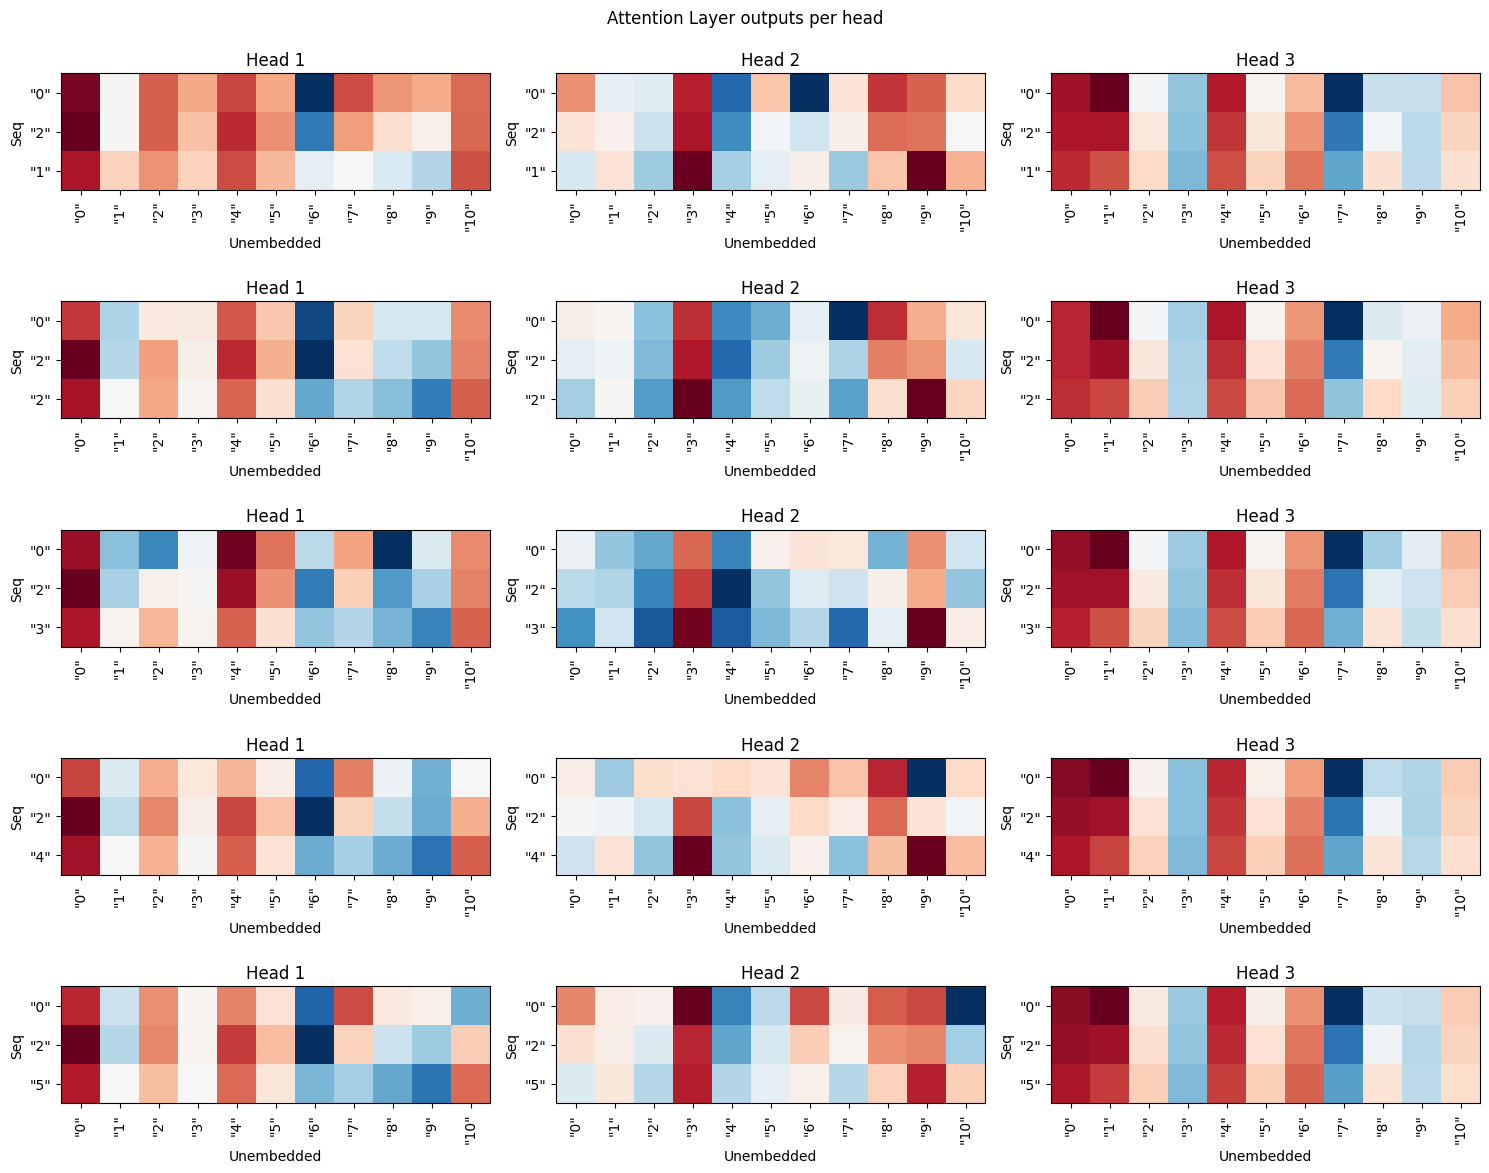

In [22]:
from numpy import average

multihead_attn = model.layer.self_attn
num_heads = cfg.n_heads

seq_ends = [1,2,3,4,5]
token_posns_to_view = [3,4,5]
f, ax = plt.subplots(len(seq_ends), num_heads, figsize=(num_heads*5,len(token_posns_to_view)*4))
for j, seq_end in enumerate(seq_ends):
    simple_seq = torch.tensor([1,5,2,0,2,seq_end,7,2,3,1], device=device).unsqueeze(0)
    output, cache = nice_hooks.run(model, simple_seq, return_activations=True)

    # attn_in = cache['pos_encod'][0].unsqueeze(0)
    # attn_in = model.layer.norm1(attn_in)
    # attn_weights = multihead_attn(attn_in, attn_in, attn_in, attn_mask=None, key_padding_mask=None, average_attn_weights=False)[1]

    manual_attn, _ = manual_attention_op(cache['layer.norm1'], multihead_attn, num_heads, average_heads=False)

    # Visualize attention outputs per head
    for i in range(num_heads):
        unembedded = einsum('v d, s d -> s v', model.embedding.weight, manual_attn[0,:,i])
        unembedded = unembedded[token_posns_to_view].detach().cpu().numpy()
            
        ax[j,i].imshow(unembedded, cmap='RdBu')
        ax[j,i].set_ylabel('Seq')
        ax[j,i].set_yticks(range(len(token_posns_to_view)))
        ax[j,i].set_yticklabels([f'"{x}"' for x in simple_seq[0,token_posns_to_view].tolist()])
        ax[j,i].set_xlabel('Unembedded')
        ax[j,i].set_xticks(range(cfg.d_vocab+1))
        ax[j,i].set_xticklabels([f'"{x}"' for x in range(cfg.d_vocab+1)], rotation=90)

        title = f'Head {i+1}'
        # if j == 0:
            # title = f'{str(simple_seq[0].tolist()).replace(" ","")}\n{title}'
        ax[j,i].set_title(title)

_ = f.suptitle('Attention Layer outputs per head')

plt.tight_layout()
plt.savefig('./results/attention_layer_outputs_per_head.png', dpi=300)

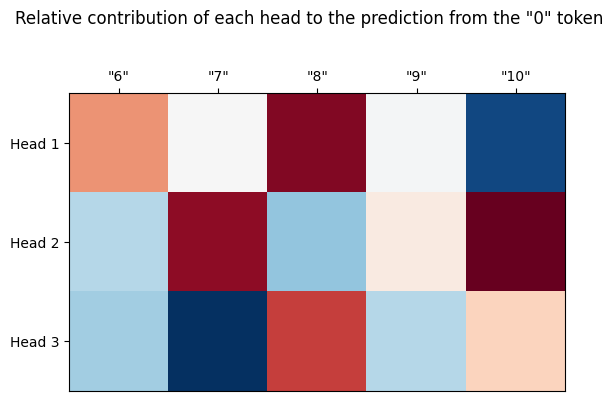

In [23]:
# Visualize the relative contributions of each head toward the correct answer on the "0" token in the sequence

seq_ends = [1,2,3,4,5]

head_contributions = torch.zeros(len(seq_ends), num_heads)
for j, seq_end in enumerate(seq_ends):
    simple_seq = torch.tensor([1,5,2,0,2,seq_end,7,2,3,1], device=device).unsqueeze(0)
    pred_tok_id = 3 # location of "0" used for prediction

    output, cache = nice_hooks.run(model, simple_seq, return_activations=True)

    manual_attn, _ = manual_attention_op(cache['layer.norm1'], multihead_attn, num_heads, average_heads=False)

    # Visualize attention outputs per head
    for i in range(num_heads):
        unembedded = einsum('v d, s d -> s v', model.embedding.weight, manual_attn[0,:,i])
        # unembedded = torch.nn.functional.softmax(unembedded, dim=-1) #! Normalize over unembedding dim - not the most sensible thing
        unembedded = unembedded[pred_tok_id, seq_end+1].item()
        head_contributions[j,i] = unembedded

f, ax = plt.subplots()
head_contributions = head_contributions.T
# append sum of columns as final row
# head_contributions = torch.cat([head_contributions, head_contributions.sum(dim=0, keepdim=True)], dim=0)
ax.imshow(head_contributions, cmap='RdBu')
# xticks at top of the plot
ax.set_xticks(range(len(seq_ends)))
ax.set_xticklabels([f'"{x+5}"' for x in seq_ends])
ax.xaxis.tick_top()
ax.set_yticks(range(num_heads))
ax.set_yticklabels([f'Head {x+1}' for x in range(num_heads)])# + ['Sum'])
f.suptitle('Relative contribution of each head to the prediction from the "0" token')
plt.savefig('./results/head_contributions.png', dpi=300)
# plt.tight_layout()
None 

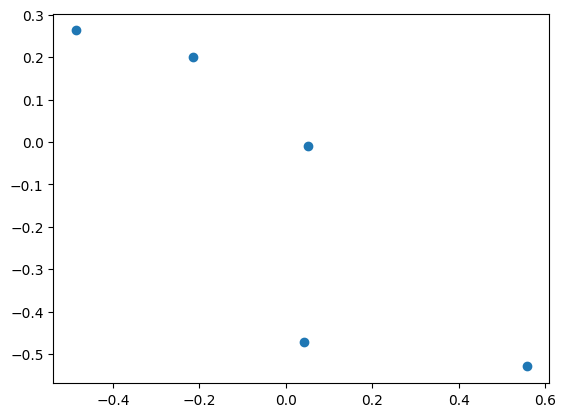

In [24]:
# visualize on 2d with heads as x,y
plt.scatter(head_contributions[0,:], head_contributions[1,:])

In [27]:
# Look at how much each head contributes to the logit of the correct digit in the residual stream 
for j, seq_end in enumerate(ending_ints):
    extracted_token_bla = {}
    simple_seq = torch.tensor([1,3,2,0,2,seq_end,7,1,2], device=device).unsqueeze(0)

    output, cache = nice_hooks.run(model, simple_seq, return_activations=True)
    # break down self_attn out into each head
    self_attn_out = cache['layer.self_attn'][0][0,3]


## Patch heads (with sign flips?) to test superposition combinations

In [ ]:

print(output)
print(cache['layer'][0,0]@model.embedding.weight.T)

tensor([[-1.2027, -3.3333, -2.3160, -2.3944, -3.1082, -3.6935,  0.7381, -0.6477,
         -0.6450, -0.2190, 10.9373]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([-1.7049, -1.9820, -2.7734, -2.9806, -1.7074, -1.4425, -0.3281,  9.8481,
         1.6045,  1.0933, -1.6727], device='cuda:0',
       grad_fn=<SqueezeBackward4>)


In [28]:
# Create the from - to attention graph 
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import numpy as np

attention_matrix = unembedded#.detach().cpu().numpy()
num_tokens = attention_matrix.shape[0]

# Create a dataframe with separate source and target tokens
df = pd.DataFrame(
    [(i, j+num_tokens, attention_matrix[i,j]) for i in range(num_tokens) for j in range(num_tokens)],  # Note the j+3 to separate target tokens
    columns=["source", "target", "value"]
)

# # Sort the label list according to the sorted source and target tokens
# labels = ["Source Token " + str(i) for i in sorted_sources] + ["Target Token " + str(i) for i in sorted_targets]
labels = ["S" + str(i) for i in range(num_tokens)] + ["T" + str(i) for i in range(num_tokens)]

# Generate Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = labels,
    ),
    link = dict(
      source = df['source'],
      target = df['target'],
      value = df['value']
  )
)])

fig.update_layout(title_text="Sankey Diagram of Attention Values", font_size=12)
fig.show()


AttributeError: 'float' object has no attribute 'shape'

In [30]:
import numpy as np
import netgraph
import matplotlib.pyplot as plt

# Assuming we have a 3x3 attention matrix
attention_matrix = unembedded#.detach().cpu().numpy() 

# Define source and target labels
source_labels = sorted([f"S{i+1}" for i in range(num_tokens)])
target_labels = sorted([f"T{j+1}" for j in range(num_tokens)])

# Create edge list with weights
edge_list = [(f"T{j}", f"S{i}", attention_matrix[j,i]) for j in range(num_tokens) for i in range(num_tokens)]
edge_width = {edge[:2]: edge[2] for edge in edge_list}

# Define node positions based on the sorted labels
node_positions = {label: (0, i) for i, label in enumerate(target_labels)}
node_positions.update({label: (1, i) for i, label in enumerate(source_labels)})

# Create a plot
fig, ax = plt.subplots()
 
# Draw the graph
netgraph.Graph(edge_list, node_positions=node_positions, node_layout='bipartite', node_labels=True)#, edge_width=edge_width, ax=ax, node_labels=True)

plt.show()


NameError: name 'num_tokens' is not defined

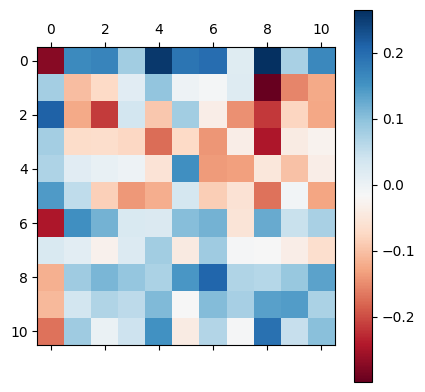

In [ ]:
unembedded = model.embedding.weight@qk@model.embedding.weight.T
from matplotlib import pyplot as plt
f = plt.matshow(unembedded.detach().cpu().numpy(), cmap='RdBu')
cbar = plt.colorbar(f)